# The CES Production Function

This notebook provides an introduction to the **Constant Elasticity of Substitution (CES)** production function, showing how it generalizes many familiar production functions including Cobb-Douglas, Leontief, and linear production functions.

This notebook was created with assistance from Claude.

## Learning Objectives

After working through this notebook, you will be able to:

- Understand the mathematical form of the CES production function
- Explain the relationship between the substitution parameter ρ and the elasticity of substitution σ
- Recognize how the CES function nests other production functions as special cases
- Visualize and interpret isoquants for different elasticities of substitution
- Understand how factor substitutability affects production choices

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider
from scipy.optimize import fsolve

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

## The CES Production Function

The CES production function is given by:

$$
Y = A\left[\alpha K^{\rho} + (1-\alpha) L^{\rho}\right]^{\frac{1}{\rho}}
$$

where:
- $Y$ is output
- $K$ is capital input
- $L$ is labor input
- $A > 0$ is a productivity parameter (total factor productivity)
- $\alpha \in (0,1)$ is a distribution parameter (share parameter)
- $\rho \leq 1$ is the **substitution parameter**

### The Elasticity of Substitution

The key feature that gives the CES function its name is that the elasticity of substitution between capital and labor is **constant** and related to ρ by:

$$
\sigma = \frac{1}{1-\rho}
$$

or equivalently:

$$
\rho = \frac{\sigma - 1}{\sigma}
$$

The elasticity of substitution $\sigma$ measures how easy it is to substitute between capital and labor while keeping output constant. Higher values of σ mean the inputs are more substitutable.

### Alternative Representation Using σ

Because the elasticity of substitution σ has a more direct economic interpretation than ρ, the CES production function is sometimes written directly in terms of σ. Substituting $\rho = \frac{\sigma-1}{\sigma}$ into the production function yields:

$$
Y = A\left[\alpha K^{\frac{\sigma-1}{\sigma}} + (1-\alpha) L^{\frac{\sigma-1}{\sigma}}\right]^{\frac{\sigma}{\sigma-1}}
$$

**Both representations are equivalent** - they describe the same production technology. The ρ-form is more compact, while the σ-form makes the economic interpretation clearer:

- When $\sigma = 0$: The exponents become $-\infty$, giving Leontief (perfect complements)
- When $\sigma = 1$: The exponents become 0/1, giving Cobb-Douglas
- When $\sigma \to \infty$: The exponents approach 1, giving perfect substitutes

In this notebook, we'll primarily use the ρ-form for implementation, but you'll see both forms in the economics literature. Trade economists and growth theorists often prefer the σ-form, while those doing numerical work often use the ρ-form.

### Special Cases

The CES function is remarkably general and includes several familiar production functions as special cases:

| Case | $\rho$ | $\sigma$ | Production Function | Name |
|------|--------|----------|---------------------|------|
| Perfect Complements | $\rho \to -\infty$ | $\sigma = 0$ | $Y = A\min(K, L)$ | Leontief |
| Cobb-Douglas | $\rho \to 0$ | $\sigma = 1$ | $Y = A K^{\alpha} L^{1-\alpha}$ | Cobb-Douglas |
| Perfect Substitutes | $\rho = 1$ | $\sigma \to \infty$ | $Y = A[\alpha K + (1-\alpha)L]$ | Linear |

**Intuition:**
- When σ = 0 (Leontief): Capital and labor must be used in fixed proportions (like one driver per truck)
- When σ = 1 (Cobb-Douglas): Moderate substitutability (the most commonly used case)
- When σ → ∞ (Linear): Capital and labor are perfect substitutes (like two types of identical workers)

## Implementing the CES Production Function

Let's implement the CES production function and its special cases:

In [2]:
def ces_production(K, L, A=1, alpha=0.5, rho=0.5):
    """
    CES production function.
    
    Parameters:
    -----------
    K : array-like
        Capital input
    L : array-like
        Labor input
    A : float
        Total factor productivity (default=1)
    alpha : float
        Distribution parameter, must be in (0,1) (default=0.5)
    rho : float
        Substitution parameter, must be ≤ 1 (default=0.5)
    
    Returns:
    --------
    Y : array-like
        Output
    """
    return A * (alpha * K**rho + (1-alpha) * L**rho)**(1/rho)

def cobb_douglas(K, L, A=1, alpha=0.5):
    """
    Cobb-Douglas production function (special case of CES when rho=0).
    """
    return A * K**alpha * L**(1-alpha)

def leontief(K, L, A=1):
    """
    Leontief production function (perfect complements, sigma=0).
    """
    return A * np.minimum(K, L)

def linear(K, L, A=1, alpha=0.5):
    """
    Linear production function (perfect substitutes, sigma=infinity).
    """
    return A * (alpha * K + (1-alpha) * L)

def rho_from_sigma(sigma):
    """
    Convert elasticity of substitution to substitution parameter.
    """
    return (sigma - 1) / sigma

def sigma_from_rho(rho):
    """
    Convert substitution parameter to elasticity of substitution.
    """
    return 1 / (1 - rho)

## Visualizing CES Isoquants

An **isoquant** shows all combinations of capital and labor that produce the same level of output. The shape of the isoquant reveals how substitutable the inputs are:

- **More curved (bowed toward origin)**: Lower σ, harder to substitute
- **Less curved (closer to straight line)**: Higher σ, easier to substitute
- **L-shaped**: σ = 0 (Leontief, perfect complements)
- **Straight line**: σ → ∞ (perfect substitutes)

Let's create a function to compute and plot isoquants:

In [3]:
def compute_isoquant(Y_target, L_range, A=1, alpha=0.5, rho=0.5):
    """
    Compute capital needed for each labor level to achieve target output.
    
    For CES: Y = A[alpha*K^rho + (1-alpha)*L^rho]^(1/rho)
    Solving for K:
    K = [(Y/A)^rho - (1-alpha)*L^rho) / alpha]^(1/rho)
    """
    L_range = np.array(L_range)
    
    # Handle special cases
    if rho == 1:  # Perfect substitutes
        K = (Y_target/A - (1-alpha)*L_range) / alpha
        return L_range, K
    
    # General CES case
    # K = [(Y/A)^rho - (1-alpha)*L^rho) / alpha]^(1/rho)
    term = (Y_target/A)**rho - (1-alpha) * L_range**rho
    
    # Only keep positive values
    valid = term > 0
    L_valid = L_range[valid]
    K_valid = (term[valid] / alpha)**(1/rho)
    
    return L_valid, K_valid

def plot_isoquants(sigma_values, Y_target=10, A=1, alpha=0.5, L_max=30):
    """
    Plot isoquants for different elasticities of substitution.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    L_range = np.linspace(0.1, L_max, 500)
    
    for sigma in sigma_values:
        # Handle special cases first to avoid division by zero
        if sigma == 0:  # Leontief
            # L-shaped isoquant
            L_vals = np.array([0, Y_target/A, Y_target/A, L_max])
            K_vals = np.array([Y_target/A, Y_target/A, 0, 0])
            label = f'σ = {sigma:.1f} (Leontief)'
        elif sigma == 1:  # Cobb-Douglas (approximate with rho close to 0)
            rho = 0.001  # Use small rho to approximate Cobb-Douglas
            L_vals, K_vals = compute_isoquant(Y_target, L_range, A, alpha, rho)
            label = f'σ = {sigma:.1f} (Cobb-Douglas)'
        elif np.isinf(sigma):  # Perfect substitutes
            rho = 1
            L_vals, K_vals = compute_isoquant(Y_target, L_range, A, alpha, rho)
            label = f'σ = ∞ (Perfect Substitutes)'
        else:
            # General CES case - now safe to call rho_from_sigma
            rho = rho_from_sigma(sigma)
            L_vals, K_vals = compute_isoquant(Y_target, L_range, A, alpha, rho)
            label = f'σ = {sigma:.2f}'
        
        ax.plot(L_vals, K_vals, linewidth=2, label=label)
    
    ax.set_xlabel('Labor (L)', fontsize=12)
    ax.set_ylabel('Capital (K)', fontsize=12)
    ax.set_title(f'CES Isoquants for Different Elasticities of Substitution\n(Output = {Y_target}, α = {alpha})', fontsize=14)
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, L_max)
    ax.set_ylim(0, L_max)
    
    plt.tight_layout()
    plt.show()

### Comparing Key Special Cases

Let's first compare the three main special cases side by side:

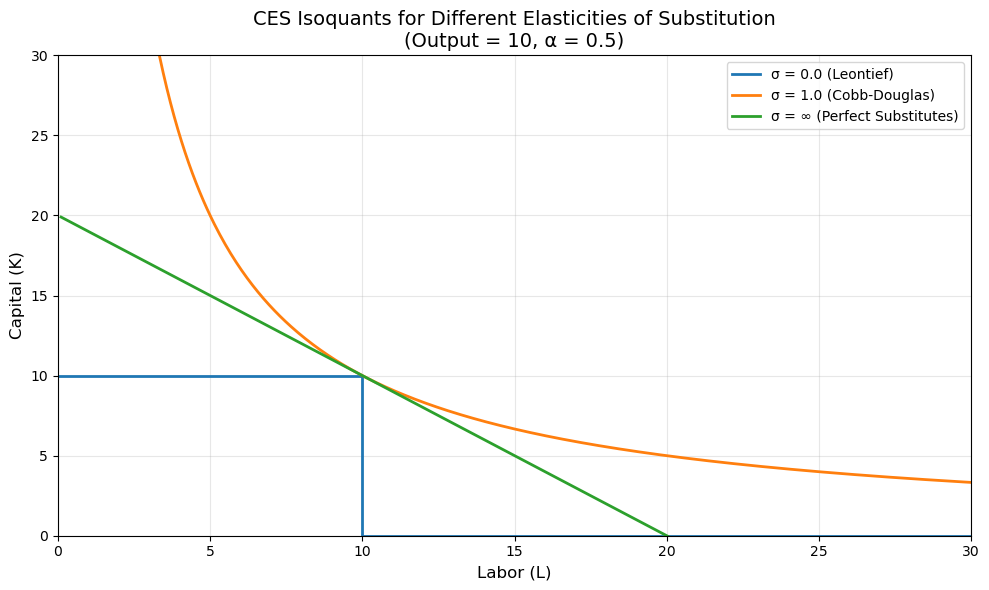

In [4]:
# Compare Leontief, Cobb-Douglas, and Perfect Substitutes
plot_isoquants(sigma_values=[0, 1, np.inf], Y_target=10, alpha=0.5)

**Interpretation:**

- **σ = 0 (Leontief, red line)**: L-shaped isoquant. Capital and labor must be used in fixed proportions. No substitution is possible - if you have 10 units of labor, you need exactly 10 units of capital to produce the target output, regardless of relative prices.

- **σ = 1 (Cobb-Douglas, orange curve)**: Moderate curvature. This is the "benchmark" case. You can substitute capital for labor (or vice versa), but with diminishing returns. This is the most commonly used production function in economics.

- **σ = ∞ (Perfect Substitutes, green line)**: Straight line. Capital and labor are perfect substitutes. You can freely exchange one for the other at a constant rate. For example, two types of workers who are equally productive.

### The Full Spectrum of Substitutability

Now let's see how isoquants change as we vary σ across a wider range:

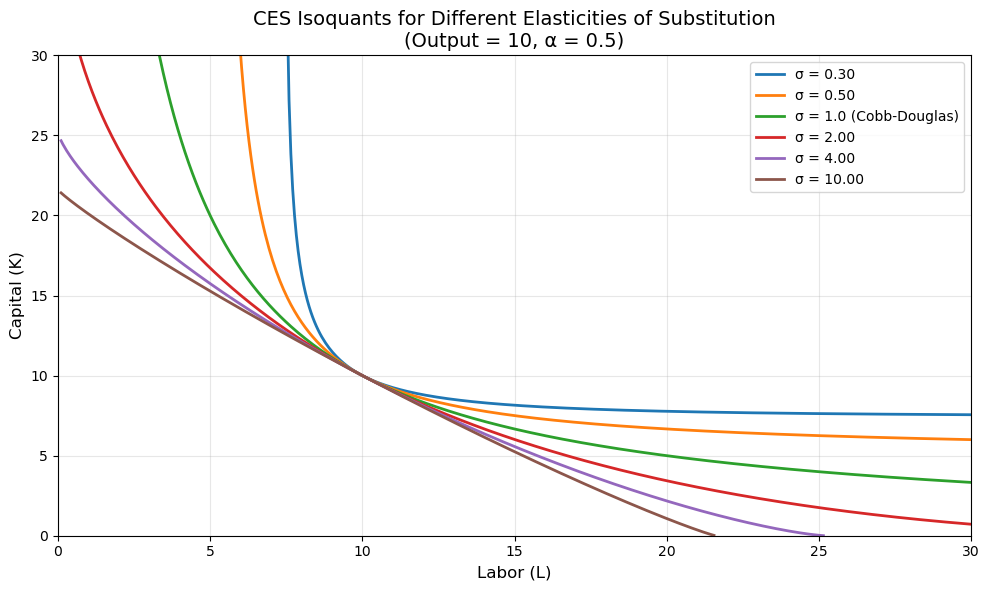

In [5]:
# Show a spectrum of sigma values
plot_isoquants(sigma_values=[0.3, 0.5, 1, 2, 4, 10], Y_target=10, alpha=0.5)

**Interpretation:**

As σ increases (moving from red to purple in the plot):

- **Low σ (0.3, 0.5)**: Isoquants are very curved. Inputs are **complements** - you need both capital and labor, and it's hard to substitute one for the other. Examples: drivers and trucks, computers and electricity.

- **σ = 1**: The Cobb-Douglas benchmark. Moderate substitutability.

- **High σ (2, 4, 10)**: Isoquants become increasingly straight. Inputs are good **substitutes**. Examples: different types of fuel, different varieties of similar crops, skilled workers who can perform similar tasks.

The curvature of the isoquant tells us about production flexibility: flatter isoquants mean more flexibility to adjust the capital-labor ratio in response to changing input prices.

## Interactive Exploration

Use the interactive widget below to explore how the elasticity of substitution affects the shape of the isoquant:

interactive(children=(FloatSlider(value=1.0, description='σ', max=5.0, min=0.1), FloatSlider(value=0.5, descri…

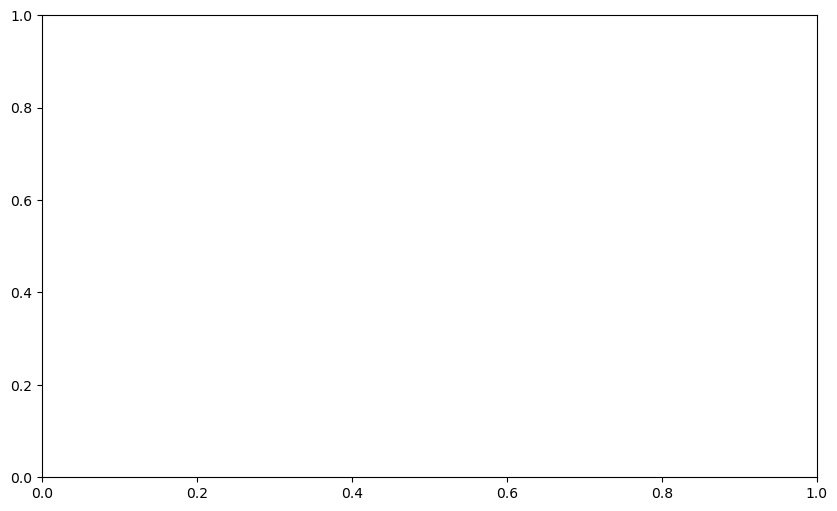

In [6]:
@interact(
    sigma=FloatSlider(min=0.1, max=5.0, step=0.1, value=1.0, description='σ'),
    alpha=FloatSlider(min=0.1, max=0.9, step=0.1, value=0.5, description='α'),
    Y_target=IntSlider(min=5, max=20, step=1, value=10, description='Output'),
)
def interactive_isoquant(sigma=1.0, alpha=0.5, Y_target=10):
    """
    Interactive plot of a single CES isoquant.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    L_range = np.linspace(0.1, 30, 500)
    rho = rho_from_sigma(sigma)
    
    # Compute isoquant
    L_vals, K_vals = compute_isoquant(Y_target, L_range, A=1, alpha=alpha, rho=rho)
    
    # Plot
    ax.plot(L_vals, K_vals, linewidth=3, color='darkblue', label=f'Y = {Y_target}')
    
    # Add reference point
    L_ref = Y_target
    if rho != 1:
        K_ref = ((Y_target)**rho - (1-alpha) * L_ref**rho) / alpha
        if K_ref > 0:
            K_ref = K_ref**(1/rho)
            ax.plot(L_ref, K_ref, 'ro', markersize=10, label=f'L={L_ref:.1f}, K={K_ref:.1f}')
    
    ax.set_xlabel('Labor (L)', fontsize=12)
    ax.set_ylabel('Capital (K)', fontsize=12)
    ax.set_title(f'CES Isoquant: σ = {sigma:.2f}, α = {alpha:.2f}, ρ = {rho:.3f}', fontsize=14)
    ax.legend(loc='upper right', fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 30)
    ax.set_ylim(0, 30)
    
    # Add interpretation text
    if sigma < 0.5:
        substitutability = "Very low substitutability (strong complements)"
    elif sigma < 1:
        substitutability = "Low substitutability (complements)"
    elif sigma == 1:
        substitutability = "Moderate substitutability (Cobb-Douglas)"
    elif sigma < 2:
        substitutability = "Moderate-high substitutability"
    else:
        substitutability = "High substitutability (good substitutes)"
    
    ax.text(0.02, 0.98, substitutability, transform=ax.transAxes,
            fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

## The Marginal Rate of Technical Substitution (MRTS)

The slope of the isoquant at any point is called the **Marginal Rate of Technical Substitution** (MRTS). It tells us how much capital we can give up for one additional unit of labor while keeping output constant:

$$
MRTS_{L,K} = -\frac{dK}{dL}\bigg|_{Y=\bar{Y}} = \frac{MP_L}{MP_K}
$$

For the CES production function:

$$
MRTS_{L,K} = \frac{1-\alpha}{\alpha} \left(\frac{K}{L}\right)^{1-\rho}
$$

**Key insight**: The MRTS depends on the capital-labor ratio (K/L) and the substitution parameter ρ:

- When **ρ is close to 1** (high σ): MRTS is nearly constant → isoquant is nearly straight
- When **ρ is very negative** (low σ): MRTS changes dramatically with K/L → isoquant is very curved
- When **ρ = 0** (Cobb-Douglas): MRTS = [(1-α)/α](K/L) → moderate curvature

In [7]:
def mrts(K, L, alpha=0.5, rho=0.5):
    """
    Marginal Rate of Technical Substitution for CES production function.
    MRTS = (1-alpha)/alpha * (K/L)^(1-rho)
    """
    return ((1-alpha)/alpha) * (K/L)**(1-rho)

@interact(
    sigma=FloatSlider(min=0.2, max=3.0, step=0.2, value=1.0, description='σ')
)
def plot_mrts(sigma=1.0):
    """
    Plot MRTS as a function of the capital-labor ratio.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    K_L_ratio = np.linspace(0.1, 5, 100)
    rho = rho_from_sigma(sigma)
    alpha = 0.5
    
    # Compute MRTS for each K/L ratio
    mrts_vals = ((1-alpha)/alpha) * K_L_ratio**(1-rho)
    
    ax.plot(K_L_ratio, mrts_vals, linewidth=3, color='darkgreen')
    ax.set_xlabel('Capital-Labor Ratio (K/L)', fontsize=12)
    ax.set_ylabel('MRTS', fontsize=12)
    ax.set_title(f'Marginal Rate of Technical Substitution\nσ = {sigma:.2f}, ρ = {rho:.3f}', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 5)
    
    # Add interpretation
    if sigma == 1:
        text = "Cobb-Douglas: MRTS proportional to K/L"
    elif sigma > 1:
        text = f"High σ: MRTS less sensitive to K/L (flatter)"
    else:
        text = f"Low σ: MRTS very sensitive to K/L (steeper)"
    
    ax.text(0.5, 0.95, text, transform=ax.transAxes,
            fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

interactive(children=(FloatSlider(value=1.0, description='σ', max=3.0, min=0.2, step=0.2), Output()), _dom_cla…

## Summary and Economic Applications

### Key Takeaways

1. **The CES production function generalizes many familiar cases**: It includes Leontief (σ=0), Cobb-Douglas (σ=1), and linear production (σ→∞) as special cases.

2. **The elasticity of substitution σ governs factor substitutability**:
   - Low σ: Factors are complements (must be used together)
   - High σ: Factors are substitutes (easily interchangeable)

3. **Isoquant shapes reveal production flexibility**:
   - Curved isoquants (low σ): Firms have less flexibility to adjust input ratios
   - Straight isoquants (high σ): Firms can easily adjust input ratios

### Economic Applications

The CES production function is used extensively in:

- **Growth theory**: Understanding how economies respond to changes in capital and labor supplies
- **International trade**: Modeling how countries with different factor endowments specialize
- **Labor economics**: Analyzing substitution between skilled and unskilled labor
- **Environmental economics**: Studying substitution between clean and dirty inputs
- **Development economics**: Examining technology adoption and factor substitution in agriculture

### Why Does σ Matter?

The elasticity of substitution has important implications:

- **Factor prices**: When σ is low, changes in factor supplies have large effects on relative prices
- **Income distribution**: The value of σ affects how economic growth is shared between capital and labor
- **Technological change**: Whether technical progress is capital-augmenting or labor-augmenting matters more when σ ≠ 1
- **Policy responses**: A firm's ability to respond to taxes or regulations depends on how easily it can substitute inputs

### Further Exploration

Try experimenting with the interactive widgets above to develop intuition for:
- How the α parameter shifts the isoquant's position
- How different industries might have different σ values
- What happens to cost minimization when input prices change for different values of σ